In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Desktop/Summer_2025/LearningToControlClass/class02`


# The content of this notebook comes from the CMU course "Optimal-Control-16-745" from Zachary Manchester:

https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%205/interior-point.ipynb

In [2]:
using LinearAlgebra
using ForwardDiff
using PyPlot

In [3]:
Q = Diagonal([0.5; 1])
# Set up QP
function f(x)
    return 0.5*(x-[1; 0])'*Q*(x-[1; 0])
end
function ∇f(x)
    return Q*(x-[1; 0])
end
function ∇2f(x)
    return Q
end

∇2f (generic function with 1 method)

In [4]:
A = [-1.0 1.0]
b = 1.0
function c(x)
    return dot(A,x) - b
end
function ∂c(x)
    return A
end

∂c (generic function with 1 method)

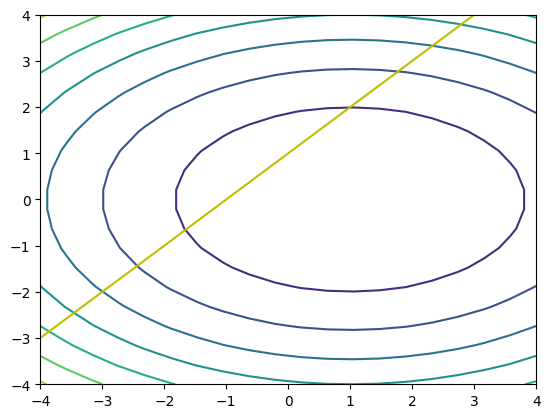

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x13e48c250>

In [5]:
function plot_landscape()
    Nsamp = 20
    Xsamp = kron(ones(Nsamp),LinRange(-4,4,Nsamp)')
    Ysamp = kron(ones(Nsamp)',LinRange(-4,4,Nsamp))
    Zsamp = zeros(Nsamp,Nsamp)
    for j = 1:Nsamp
        for k = 1:Nsamp
            Zsamp[j,k] = f([Xsamp[j,k]; Ysamp[j,k]])
        end
    end
    contour(Xsamp,Ysamp,Zsamp)

    xc = LinRange(-4,3,Nsamp)
    plot(xc,xc.+1,"y")
end

# feasible region is defined by inequality constraint
plot_landscape()

In [6]:
# The residual function; i.e the F.O.N.C that needs to be zero
function ip_residual(z, ρ)
    x = z[1:2]
    σ = z[3]
    r = [∇f(x) - ∂c(x)'*sqrt(ρ)*exp(-σ);
         c(x) - sqrt(ρ)exp(σ)]
end

ip_residual (generic function with 1 method)

In [7]:
# this is the actual true stock KKT system
function kkt_residual(z)
    x = z[1:2]
    σ = z[3]
    λ = sqrt(ρ)*exp(-σ)

    r = [∇f(x) - ∂c(x)'*λ;
         min(λ, 0)
         min(c(x),0)
         λ*c(x)]
end

kkt_residual (generic function with 1 method)

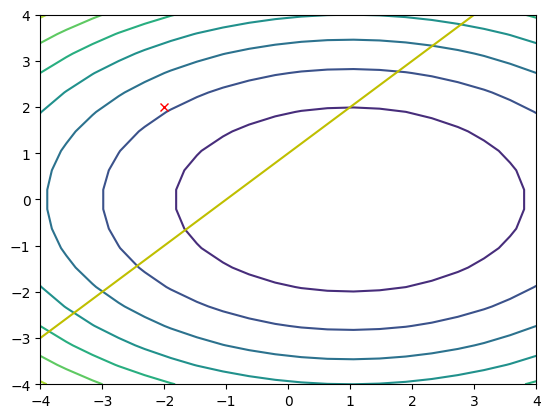

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x13f315840>

In [8]:
xguess = [-2; 2] # we are in the interior
σguess = 0.0
z = [xguess; σguess]
plot_landscape()
plot(z[1], z[2], "rx")

In [9]:
ρ = 1.0
ip_residual(z,ρ)

3×1 Matrix{Float64}:
 -0.5
  1.0
  2.0

In [10]:
kkt_residual(z)

5×1 Matrix{Float64}:
 -0.5
  1.0
  0.0
  0.0
  3.0

In [11]:
function newton_solve(z0,ρ,tol)

    #initial guess
    z = z0
    
    #KKT residual
    r = ip_residual(z,ρ)

    # while not converged
    while norm(r) > tol       
        #H = ∇2f(x)
        #C = ∂c(x)

        #M = [H sqrt(ρ)*C'*exp(-σ);
        #    C -sqrt(ρ)*exp(σ)]

        #Newton step: evaluate jacobian of residal
        M = ForwardDiff.jacobian(dz->ip_residual(dz,ρ), z)
        Δz = -M\r

        znew = z + Δz
        rnew = ip_residual(znew,ρ)

        #Line search with armijo
        b = 0.1
        c = 0.5
        α = 1.0
        while norm(rnew) > (norm(r) + b*α*dot(r,M*Δz)/norm(r))
            α = c*α
            znew = z + α*Δz
            rnew = ip_residual(znew,ρ)
        end

        z = znew
        r = rnew
    end

    return z
end

newton_solve (generic function with 1 method)

In [12]:
z_iter = z

3-element Vector{Float64}:
 -2.0
  2.0
  0.0

In [13]:
ρ = 1.0  
z = newton_solve(z_iter[:,end],ρ,1e-10) # a relaxed solution
z_iter = [z_iter z]

3×2 Matrix{Float64}:
 -2.0  -1.0
  2.0   1.0
  0.0   0.0

In [14]:
kkt_residual(z)
# super cool, basically the residual error's are zero everywhere except the complementarity as that is what we relaxed

5×1 Matrix{Float64}:
 0.0
 0.0
 0.0
 0.0
 1.0

In [15]:
ip_residual(z,ρ)

3×1 Matrix{Float64}:
 0.0
 0.0
 0.0

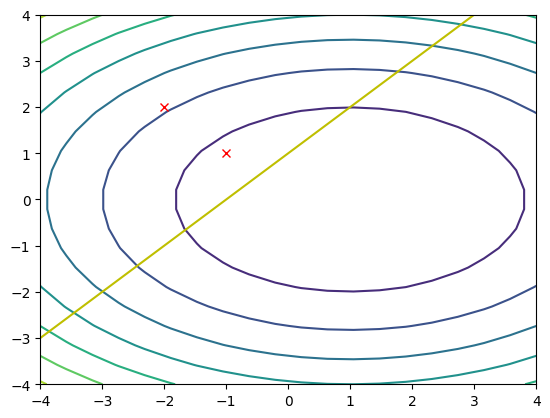

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3070781c0>

In [16]:
plot_landscape()
plot(z_iter[1,:], z_iter[2,:], "rx") # Need to keep on driving rho down closer to 0 to approach constraint

In [17]:
ρ = 1.0e-8 #adjust from ρ=1 to ρ=1e-8 to observe convergence along central path. Warm start with prior iter
z = newton_solve(z_iter[:,end],ρ,1e-10)
z_iter = [z_iter z]

3×3 Matrix{Float64}:
 -2.0  -1.0  -0.333333
  2.0   1.0   0.666667
  0.0   0.0  -8.80488

In [18]:
kkt_residual(z) # amazing, super close to now satisfying the original kkt conditions

5×1 Matrix{Float64}:
  2.8343993818680246e-13
 -2.8343993818680246e-13
  0.0
  0.0
  1.000000001422954e-8

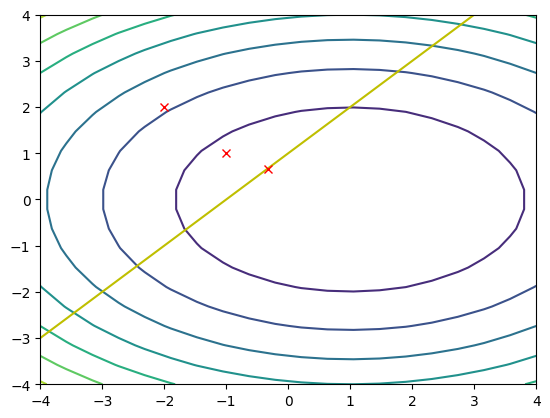

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3070ea230>

In [19]:
plot_landscape()
plot(z_iter[1,:], z_iter[2,:], "rx")
# the path that the solution follows as you crank rho down is called the "central path"

In [20]:
M = ForwardDiff.jacobian(dz->ip_residual(dz,ρ), z)

3×3 Matrix{Float64}:
  0.5  0.0  -0.666667
  0.0  1.0   0.666667
 -1.0  1.0  -1.5e-8

In [21]:
eigvals(M)

3-element Vector{Float64}:
 -0.8526850467837964
  0.7169780264777998
  1.6357070053059972